In [181]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.mixture import GaussianMixture


rng = np.random.default_rng()

In [182]:
class SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej', 'log_vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_dict):
        self.true_class = true_class
        if self.true_class == 'ia':
            self.true_params = {key:true_dict[key] for key in self.ia_keys}
        elif self.true_class == 'ibc':
            self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        else:
            raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}
        self.ibc_fit.update({'log_vej': np.log10(self.ibc_fit['vej'])})

In [183]:
data = np.load("fitted_sne_100_091025.npz", allow_pickle=True)
true_ia_sne = data['ia']
true_ibc_sne = data['ibc']
all_sne = np.concatenate((true_ia_sne, true_ibc_sne))
len(true_ibc_sne), len(all_sne)


(100, 200)

In [184]:
for sn in all_sne:
    sn.ibc_fit.update({'log_vej': np.log10(sn.ibc_fit['vej'])})

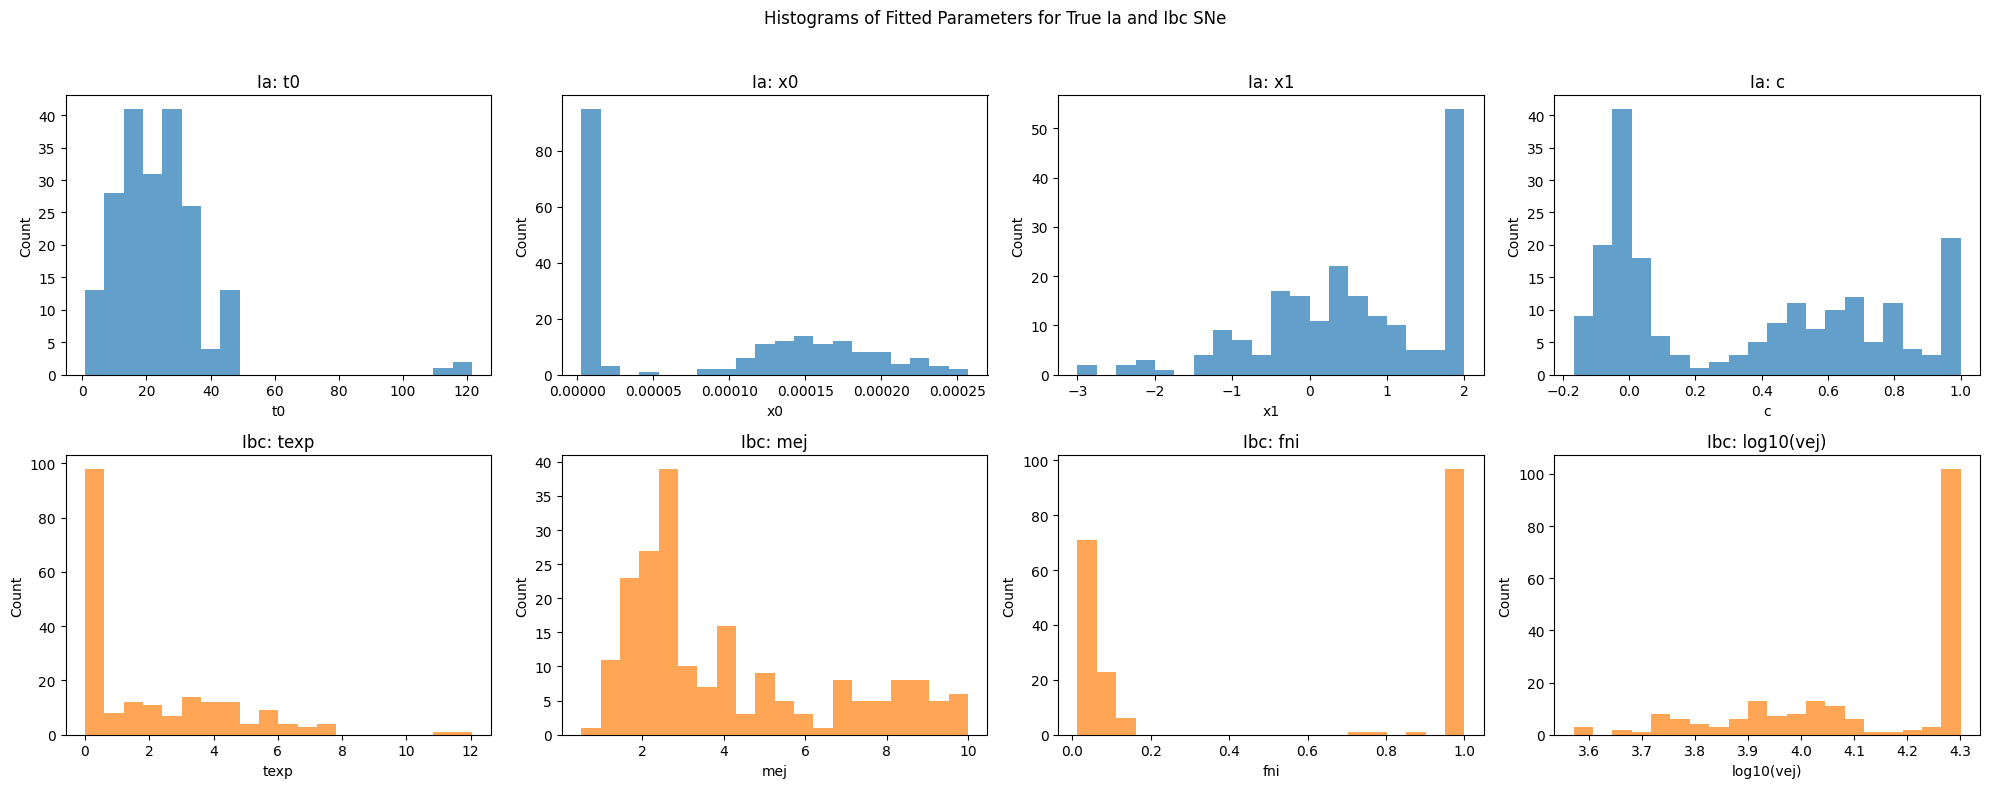

In [185]:
ia_param_names = SN.ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = SN.ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names):
    values = [sn.ia_fit[param] for sn in all_sne if sn.ia_fit[param] is not None]
    axes[0, i].hist(values, bins=20, color='tab:blue', alpha=0.7)
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values = [sn.ibc_fit[param] for sn in all_sne if sn.ibc_fit[param] is not None]
    if param == 'vej':
        # Plot log10 for vej
        values = [np.log10(v) for v in values if v > 0]
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Here we have 8 parameters that we can use to constrain the mixing fraction

In [186]:
# This is the log likelihood function for the distribution of one parameter 
# assuming a mixture of two Gaussians.
# x is the parameter value, samples are the observed data, and alpha is the mixing fraction
def log_likelihood(x, samples, alpha):
    mu1, sigma1, mu2, sigma2 = x
    first_term = alpha * norm.pdf(samples, mu1, sigma1)
    second_term = (1 - alpha) * norm.pdf(samples, mu2, sigma2)
    return np.sum(np.log(first_term + second_term))

In [187]:
def get_param_samples(param_name):
    if param_name in ia_param_names:
        return np.array([sn.ia_fit[param_name] for sn in all_sne])
    elif param_name in ibc_param_names:
        return np.array([sn.ibc_fit[param_name] for sn in all_sne])
    else:
        raise ValueError(f"Parameter {param_name} not recognized in either Ia or Ibc SNe.")

(array([94.,  6.,  0.,  0.,  0.,  0.,  0.,  2.,  1., 97.]),
 array([0.01290493, 0.11161443, 0.21032394, 0.30903345, 0.40774296,
        0.50645246, 0.60516197, 0.70387148, 0.80258099, 0.90129049,
        1.        ]),
 <BarContainer object of 10 artists>)

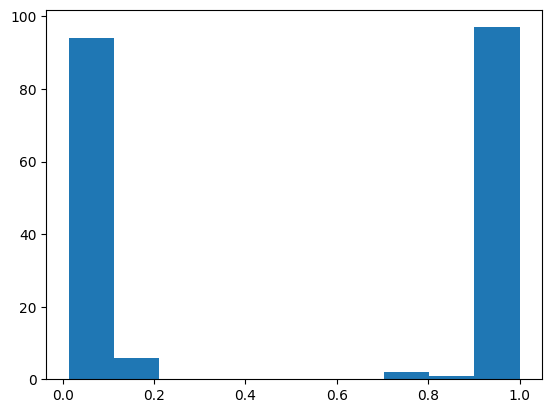

In [188]:
plt.hist(get_param_samples('fni'))

In [189]:
np.shape(get_param_samples('log_vej').reshape(-1, 1))

(200, 1)

In [190]:
# Fit initial guesses
params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'x0', 'fni', 'log_vej']

mus_a = {}
mus_b = {}
sigmas_a = {}
sigmas_b = {}

for param_name in params_to_use:
    samples = get_param_samples(param_name).reshape(-1, 1)
    gm = GaussianMixture(n_components=2).fit(samples)
    mus_a[param_name] = gm.means_[0][0]
    mus_b[param_name] = gm.means_[1][0]
    sigmas_a[param_name] = np.sqrt(gm.covariances_[0][0][0])
    sigmas_b[param_name] = np.sqrt(gm.covariances_[1][0][0])
    print(param_name, gm.weights_)

t0 [0.985 0.015]
c [0.47016504 0.52983496]
mej [0.27698649 0.72301351]
texp [0.54006461 0.45993539]
x1 [0.23987972 0.76012028]
x0 [0.50485069 0.49514931]
fni [0.5 0.5]
log_vej [0.49017911 0.50982089]


In [191]:
# from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2).fit(get_param_samples('x1').reshape(-1, 1))
gm.means_, gm.covariances_**0.5, gm.weights_

(array([[0.10834486],
        [1.9999948 ]]),
 array([[[0.97942327]],
 
        [[0.00100031]]]),
 array([0.76012028, 0.23987972]))

In [192]:
num_epochs = 200
lls = np.zeros(num_epochs)


# mus_a = {'t0': 20, 'x0': 0.0001, 'x1': 2, 'c': 0, 'texp': 0.5, 'mej': 8, 'fni': 0.05, 'log_vej': 4.3}
# mus_b = {'t0': 20, 'x0': 0.0001, 'x1': 0.5, 'c': 0.6, 'texp': 5, 'mej': 2, 'fni': 0.49, 'log_vej': 3.9}
# sigmas_a = {'t0': 10, 'x0': 5e-4, 'x1': 0.01, 'c': 0.1, 'texp': 0.2, 'mej': 2, 'fni': 0.01, 'log_vej': 0.05}
# sigmas_b = {'t0': 10, 'x0': 5e-4, 'x1': 1, 'c': 0.3, 'texp': 3, 'mej': 2, 'fni': 5e-2, 'log_vej': 0.2}


alphas = np.zeros(num_epochs)  # Store alpha values for each epoch
alpha = 0.1  # Mixing fraction
gammas_a = {'texp': [], 'mej': [], 'fni': [], 'log_vej': [], 't0': [], 'x0': [], 'x1': [], 'c': []}
gammas_b = {'texp': [], 'mej': [], 'fni': [], 'log_vej': [], 't0': [], 'x0': [], 'x1': [], 'c': []}

params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'x0', 'fni', 'log_vej']
# params_to_use = list(mus_a.keys())  # Use all parameters for fitting



# there are two populations, a and b
for epoch in range(num_epochs):
    # for param_name in list(mus_a.keys())[:3]:
    for param_name in params_to_use:
        param_samples = get_param_samples(param_name)

        # plt.hist(param_samples)
        # plt.show()

        # print(mus_a[param_name], sigmas_a[param_name])
        # the gammas are weights for every sample
        gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
        gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])
        
        # print(param_name)
        # print(np.sum(gammas_a[param_name]), np.sum(gammas_b[param_name]))
        # print(sum(np.isnan(gammas_a[param_name])), sum(np.isinf(gammas_a[param_name])))

        # Normalize over parameter
        gamma_total = (gammas_a[param_name] + gammas_b[param_name])
        gammas_a[param_name] /= gamma_total
        gammas_b[param_name] /= gamma_total
        

        mus_a[param_name] = np.sum(gammas_a[param_name] * param_samples) / np.sum(gammas_a[param_name])
        mus_b[param_name] = np.sum(gammas_b[param_name] * param_samples) / np.sum(gammas_b[param_name])
        sigmas_a[param_name] = np.sqrt(np.sum(gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(gammas_a[param_name]))
        sigmas_b[param_name] = np.sqrt(np.sum(gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(gammas_b[param_name]))

    
    # Here we can use information from all parameters to constrain the mixing fraction
    # alpha is the fraction of parameter a, parameter b has 1 - alpha
    alpha = np.mean(np.concatenate([gammas_a[param_name] for param_name in params_to_use]))
    alphas[epoch] = alpha
    print("Alpha", alpha)

    # Calculate log likelihood for the current epoch
    for param_name in params_to_use:
        lls[epoch] += log_likelihood([mus_a[param_name], sigmas_a[param_name], mus_b[param_name], sigmas_b[param_name]], get_param_samples(param_name), alpha)

    

Alpha 0.4447367596932
Alpha 0.4914143237487434
Alpha 0.5013128172857565
Alpha 0.5064490593631159
Alpha 0.510973571839607
Alpha 0.514886496633313
Alpha 0.5187556131645088
Alpha 0.5224476243278884
Alpha 0.5256895759133862
Alpha 0.5282678922458731
Alpha 0.5300600034796695
Alpha 0.5308695856386124
Alpha 0.5315908420301264
Alpha 0.5321047049742275
Alpha 0.5323282499252215
Alpha 0.5322512183239195
Alpha 0.5323529892701682
Alpha 0.5324475326239542
Alpha 0.5325133622528108
Alpha 0.5325563005507612
Alpha 0.5325838113965443
Alpha 0.5326013211794093
Alpha 0.5326124292066595
Alpha 0.5326194626384264
Alpha 0.5326239108027674
Alpha 0.5326267218035408
Alpha 0.5326284973141704
Alpha 0.5326296184094068
Alpha 0.5326303261393303
Alpha 0.5326307728543768
Alpha 0.5326310547917855
Alpha 0.5326312327213032
Alpha 0.5326313450072786
Alpha 0.5326314158656873
Alpha 0.5326314605803142
Alpha 0.5326314887967838
Alpha 0.5326315066022267
Alpha 0.5326315178379314
Alpha 0.5326315249279406
Alpha 0.5326315294018925
Alpha

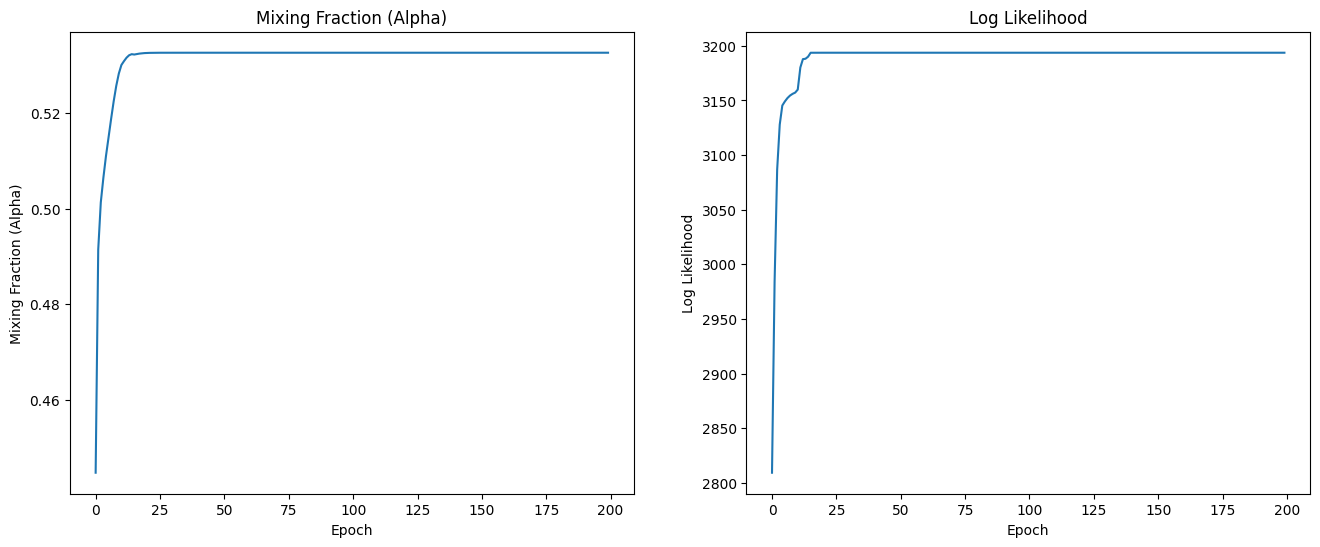

In [193]:
fig, ax = plt.subplots(1,2, figsize=(16, 6))
ax[0].plot(alphas)
ax[1].plot(lls)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Mixing Fraction (Alpha)")
ax[0].set_title("Mixing Fraction (Alpha)")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Log Likelihood")
ax[1].set_title("Log Likelihood")

plt.show()

In [194]:
mus_a, mus_b, sigmas_a, sigmas_b

({'t0': 22.367745183914206,
  'c': -0.025362335102419364,
  'mej': 5.972153306938793,
  'texp': 3.4860487469338564,
  'x1': 1.999999626477365,
  'x0': 8.684640548235184e-05,
  'fni': 0.9938933541051719,
  'log_vej': 3.9388565594512603},
 {'t0': 118.0264037572114,
  'c': 0.6717986482235444,
  'mej': 2.2513252286764436,
  'texp': 1.356988256659355e-07,
  'x1': 0.1566598856422861,
  'x0': 8.459160889241827e-05,
  'fni': 0.051641790268811466,
  'log_vej': 4.301029989386681},
 {'t0': 11.180098384206467,
  'c': 0.058728706518710726,
  'mej': 2.4304870733972637,
  'texp': 2.2803015965498843,
  'x1': 9.301270785048553e-07,
  'x0': 8.284824930738442e-05,
  'fni': 0.03647546650236838,
  'log_vej': 0.1501410034894646},
 {'t0': 3.8194792169145337,
  'c': 0.23077645312665757,
  'mej': 0.5607899117184739,
  'texp': 2.3558217188192801e-07,
  'x1': 1.0118426621102934,
  'x0': 8.242873846760407e-05,
  'fni': 0.030630184997211547,
  'log_vej': 1.1501933250311402e-08})

In [202]:
for n in sigmas_b.keys():
    if sigmas_b[n] < 0.01:
        sigmas_b[n] = 0.01

for n in sigmas_a.keys():
    if sigmas_a[n] < 0.01:
        sigmas_a[n] = 0.01

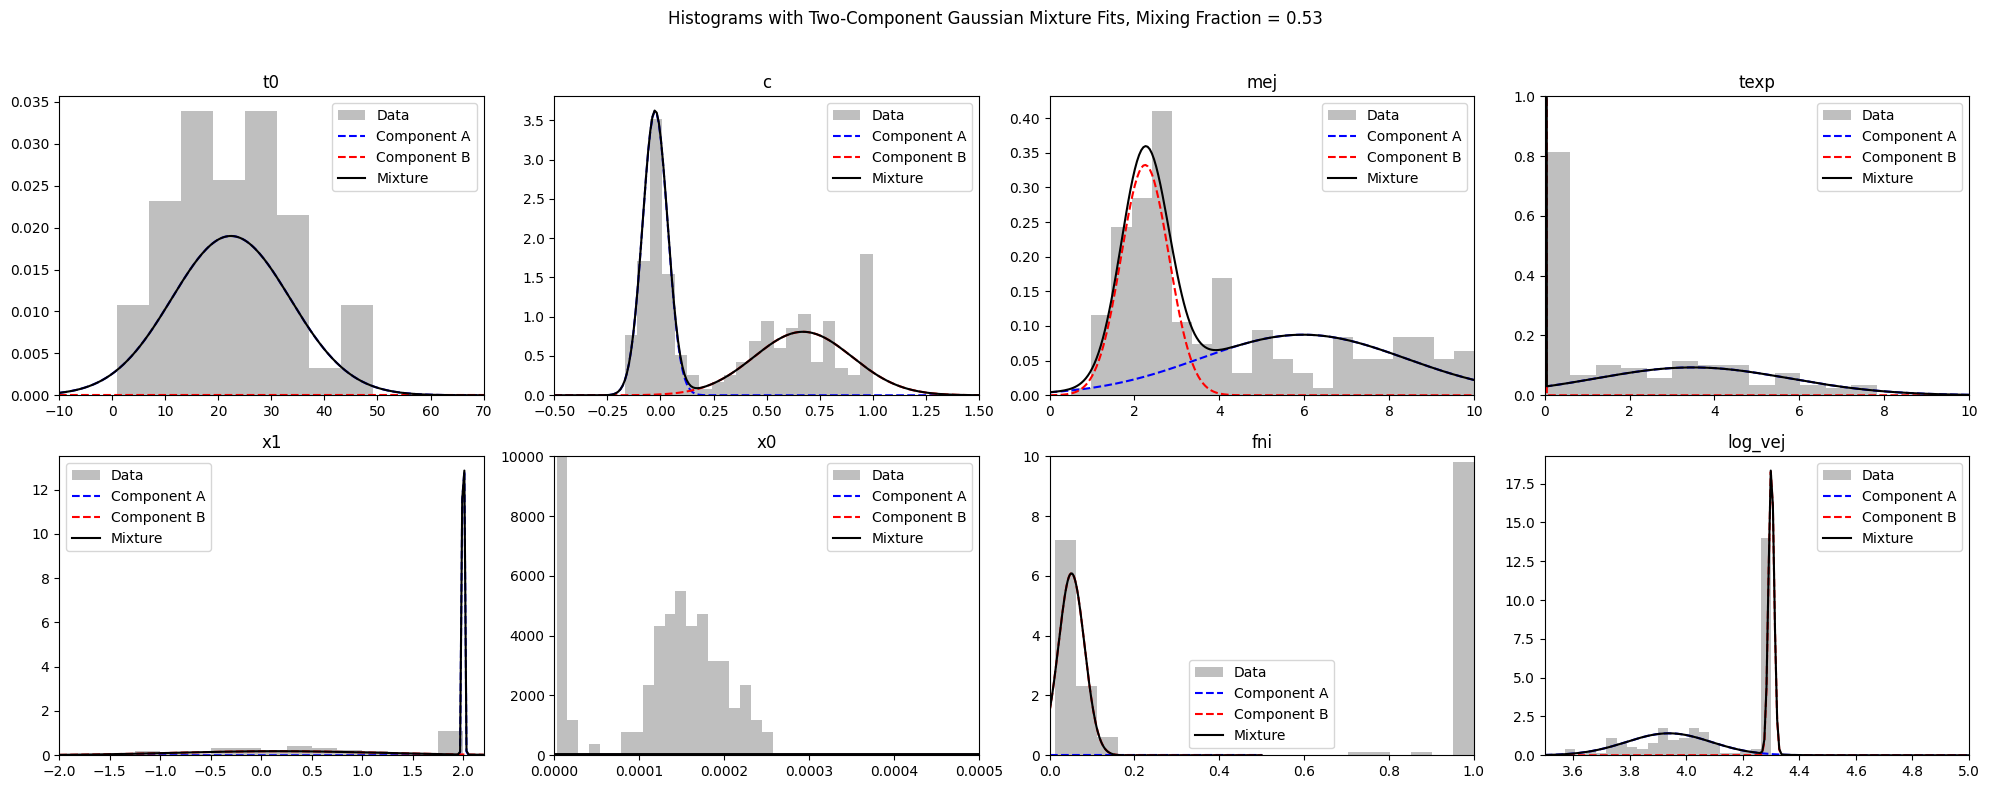

In [209]:
x_ranges = {
    't0': np.linspace(-10, 70, 200),
    'x0': np.linspace(-0.001, 0.001, 200),
    'x1': np.linspace(-2, 2.2, 200),
    'c': np.linspace(-0.5, 1.5, 200),
    'texp': np.linspace(0, 10, 200),
    'mej': np.linspace(0, 10, 200),
    'fni': np.linspace(0, 0.5, 200),
    'log_vej': np.linspace(3.5, 5, 200)
}

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms with Two-Component Gaussian Mixture Fits, Mixing Fraction = {:.2f}".format(alpha))

for idx, param in enumerate(params_to_use):
    samples = get_param_samples(param)
    ax = axes.flat[idx]
    ax.hist(samples, bins=20, density=True, alpha=0.5, color='gray', label='Data')
    x = x_ranges[param]
    # Mixture fit
    y_a = alpha * norm.pdf(x, mus_a[param], sigmas_a[param])
    y_b = (1 - alpha) * norm.pdf(x, mus_b[param], sigmas_b[param])
    y_mix = y_a + y_b
    ax.plot(x, y_a, 'b--', label='Component A')
    ax.plot(x, y_b, 'r--', label='Component B')
    ax.plot(x, y_mix, 'k-', label='Mixture')
    ax.set_title(param)
    ax.set_xlim(x[0], x[-1])  # Ensure curves span the full x range
    if param == 'texp':
        ax.set_ylim(0, 1)  # Reduce y-limits for texp to see the histogram
    elif param == 'fni':
        ax.set_ylim(0, 10)
        ax.set_xlim(0, 1)
    elif param == 'x0':
        ax.set_ylim(0, 10000)
        ax.set_xlim(0, 0.0005)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()